# Approaches for predicting the area of forest that will be destroyed by fire based on meteorological data

In [2]:
# basic imports to work with data

import numpy as np
import pandas as pd

# visualization imports

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# feature selection import

from sklearn.feature_selection import RFE

# import to split datatset on train/test

from sklearn.model_selection import train_test_split

# import main methods to implement Random Forest, Decision Trees, SVR algorithms

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# import metrics to evaluate models quality

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
from sklearn.model_selection import cross_val_score

# import methods to implement ANN

from keras.models import Sequential
import keras.optimizers as opti
from keras.layers import Dense, Activation,Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [3]:
# load dataset
df = pd.read_csv(r"forestfires.csv")

#### Description of dataset:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9 
3. month - month of the year: 'jan' to 'dec' 
4. day - day of the week: 'mon' to 'sun' 
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20 
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10 
9. temp - temperature in Celsius degrees: 2.2 to 33.30 
10. RH - relative humidity in %: 15.0 to 100 
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
(this output variable is very skewed towards 0.0, thus it may make 
sense to model with the logarithm transform)

In [4]:
# Encode Data
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

### Using resampling to resolve a problem of lack of data

In [5]:
from sklearn.utils import resample
boot = resample(df, replace=True, n_samples=10000, random_state=1)

In [6]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
df.shape

(517, 13)

In [8]:
df.dtypes

X          int64
Y          int64
month      int64
day        int64
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

### Print main statistical characteristics of the data and check for empty values

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
month,517.0,7.475822,2.275990,1.0,7.0,8.00,9.00,12.00
day,517.0,4.259188,2.072929,1.0,2.0,5.00,6.00,7.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00


In [10]:
for i in df.columns:
    print(str(i) + ' has n/a values? ' + str(df[i].isna().unique()))

X has n/a values? [False]
Y has n/a values? [False]
month has n/a values? [False]
day has n/a values? [False]
FFMC has n/a values? [False]
DMC has n/a values? [False]
DC has n/a values? [False]
ISI has n/a values? [False]
temp has n/a values? [False]
RH has n/a values? [False]
wind has n/a values? [False]
rain has n/a values? [False]
area has n/a values? [False]


In [11]:
dfa = df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()

### Display information about the categorical features - day and month

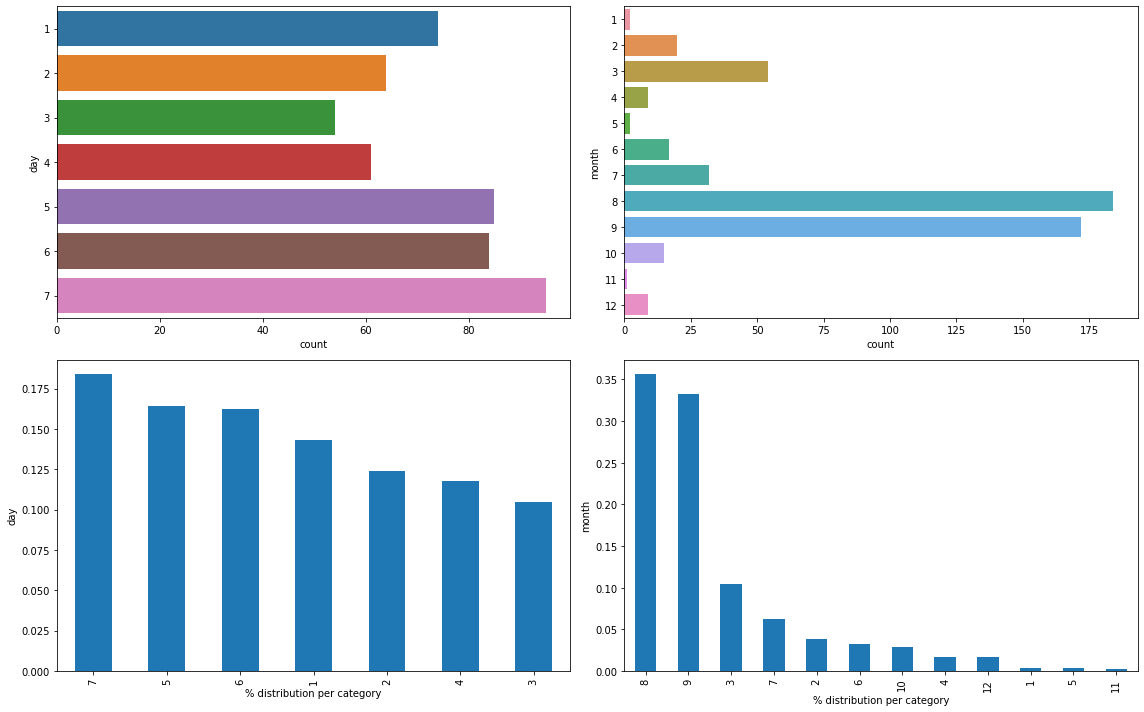

In [12]:
plt.figure(figsize=(16,10))
for i,col in enumerate(['day','month'],1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()    

### Build a correlation matrix and visualize it in a more convenient way

In [13]:
df.corr(method='pearson')

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


[Text(0, 0, 'X'),
 Text(0, 1, 'Y'),
 Text(0, 2, 'month'),
 Text(0, 3, 'day'),
 Text(0, 4, 'FFMC'),
 Text(0, 5, 'DMC'),
 Text(0, 6, 'DC'),
 Text(0, 7, 'ISI'),
 Text(0, 8, 'temp'),
 Text(0, 9, 'RH'),
 Text(0, 10, 'wind'),
 Text(0, 11, 'rain'),
 Text(0, 12, 'area')]

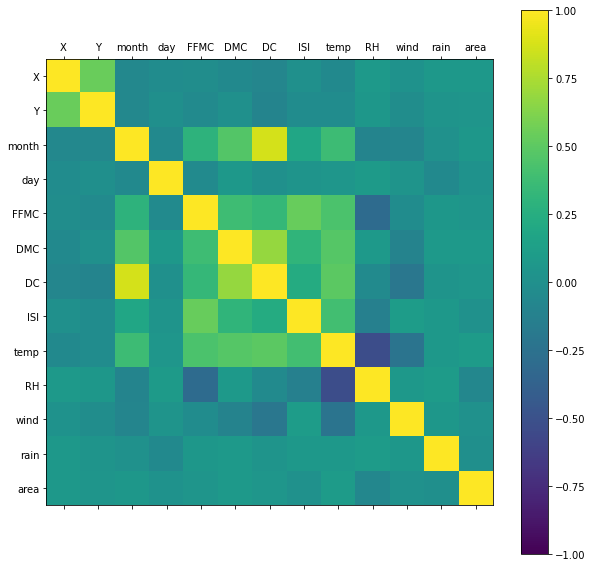

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,13,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)

### Perform a logarithmic transformation of the target variable in order to normalize it, visualize the result

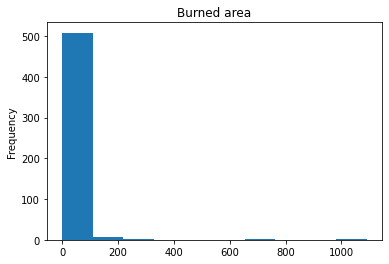

In [15]:
plt.hist((df.area), label='Burned area')
plt.ylabel('Frequency')
plt.title(r'Burned area')
plt.show()

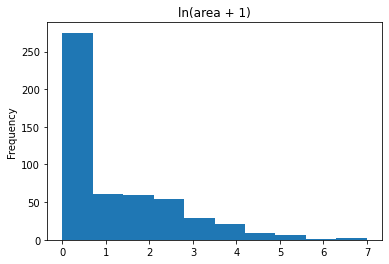

In [16]:
plt.hist((np.log(df.area+1)))
plt.ylabel('Frequency')
plt.title(r'ln(area + 1)')
plt.show()

In [17]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
df['area'] = np.array(df['area']).reshape((len(df['area']), 1))
df['area'] = np.log(df['area']+1)

In [24]:
boot['area'] = np.array(boot['area']).reshape((len(boot['area']), 1))
boot['area'] = np.log(boot['area']+1)

<ipython-input-24-ee1205cc84ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boot['area'] = np.array(boot['area']).reshape((len(boot['area']), 1))
<ipython-input-24-ee1205cc84ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boot['area'] = np.log(boot['area']+1)


### Add a function to perform normalization for all other variables, making mean equals 0 and variance equals 1 

In [25]:
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std
    
# call the z_score function
df_STD = z_score(df)

df_STD

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.007337,0.569309,-1.966538,0.357375,-0.805180,-1.322045,-1.828706,-0.860113,-1.840857,0.411326,1.497164,-0.073197,-0.794477
1,1.007337,-0.243765,1.109046,-1.089853,-0.008094,-1.178399,0.488418,-0.509195,-0.153130,-0.691786,-1.740070,-0.073197,-0.794477
2,1.007337,-0.243765,1.109046,0.839784,-0.008094,-1.048806,0.560173,-0.509195,-0.738668,-0.691786,-1.516813,-0.073197,-0.794477
3,1.439531,1.382383,-1.966538,0.357375,0.191177,-1.211188,-1.896429,-0.004751,-1.823636,3.230391,-0.009824,0.602572,-0.794477
4,1.439531,1.382383,-1.966538,1.322193,-0.243597,-0.930142,-1.796859,0.126843,-1.289763,3.352959,-1.237741,-0.073197,-0.794477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.289244,-1.056839,0.230308,1.322193,-1.638496,-0.845829,0.474309,-1.561947,1.534597,-0.753070,-0.735411,-0.073197,0.640605
513,-1.153631,-0.243765,0.230308,1.322193,-1.638496,-0.845829,0.474309,-1.561947,0.518517,1.637006,0.994835,-0.073197,2.074865
514,1.007337,-0.243765,0.230308,1.322193,-1.638496,-0.845829,0.474309,-1.561947,0.397965,1.575722,1.497164,-0.073197,0.991913
515,-1.585825,-0.243765,0.230308,0.839784,0.680298,0.548471,0.269122,0.499693,1.155720,-0.140230,-0.009824,-0.073197,-0.794477


In [26]:
boot_STD = z_score(boot)

### Split the sample into training and test in the ratio of 80/20

In [27]:
train, test = train_test_split(df_STD, test_size=0.2)
train_x = train[['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
train_y = train['area']
test_x = test[['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
test_y = test['area']

In [28]:
train, test = train_test_split(boot_STD, test_size=0.2)
train_x = train[['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
train_y = train['area']
test_x = test[['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
test_y = test['area']

### Add a method for constructing REC curves

In [57]:
tol_max=20
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [54]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [3, 10, 100, 1000],
            'gamma': [0.1, 1]
        },
        cv=5, scoring='r2', verbose=0, n_jobs=-1)

In [55]:
grid.fit(train_x,train_y)
print("best parameters are: ", grid.best_params_)

best parameters are:  {'C': 10, 'gamma': 1}


RandomForest
MAE 0.014355622656565986
MSE 0.008538103886378602
RMSE 0.09240186083828941
R^2 0.9910928319724388
ExtraTreesRegressor
MAE 0.014251938461186076
MSE 0.0085718360322038
RMSE 0.09258421049079481
R^2 0.9910572748949082
DecisionTreeRegressor
MAE 0.014251938461185575
MSE 0.008571836032203803
RMSE 0.09258421049079484
R^2 0.9910572748949082
SVR
MAE 0.10632767394268189
MSE 0.020787782986053535
RMSE 0.14417968992217153
R^2 0.9747425737836866


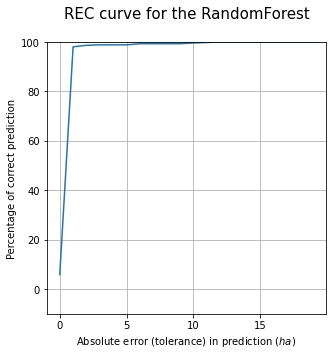

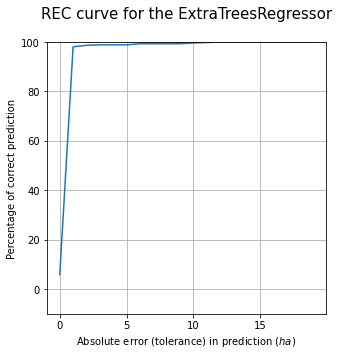

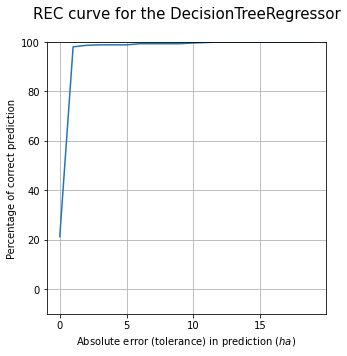

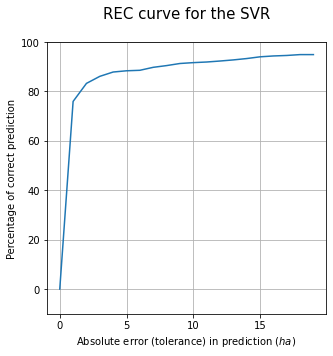

In [65]:
num_instances = len(train_x)
models = []

models.append(('RandomForest', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('SVR', SVR(C=10, kernel='rbf', gamma=1)))

# evaluations
results = []
names = []
scoring = []

for name, model in models:
    # fit the model
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    # evaluate the model
    mae = mean_absolute_error(predictions, test_y)
    mse = mean_squared_error(predictions, test_y)
    rmse = np.sqrt(mse)
    r_squared = r2_score(predictions, test_y)
    print(name)
    print('MAE '+ str(mae))
    print('MSE '+ str(mse))
    print('RMSE '+ str(rmse))
    print('R^2 '+ str(r_squared))
    rec_=[]
    for i in range(20):
        rec_.append(rec(predictions,test_y,i))

    plt.figure(figsize=(5,5))
    plt.title("REC curve for the "+str(name)+"\n",fontsize=15)
    plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
    plt.ylabel("Percentage of correct prediction")
    plt.xticks([i*5 for i in range(20+1)])
    plt.ylim(-10,100)
    plt.yticks([i*20 for i in range(6)])
    plt.grid(True)
    plt.plot(range(20),rec_)

### Add Neural Network

In [66]:
model = Sequential()
model.add(Dense(200, input_dim=12))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Activation('selu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(1))

In [59]:
learning_rate=0.0001
optimizer = opti.RMSprop(lr=learning_rate)
model.compile(optimizer=optimizer,loss='mse')

In [62]:
model.fit(train_x, train_y, epochs=600, batch_size=10,verbose=0)

In [63]:
y_pred = model.predict(test_x)
print('MSE: '+ str(mean_squared_error(y_pred, test_y)))
print('MAE: '+ str(mean_absolute_error(y_pred, test_y)))
print('R2: '+ str(r2_score(y_pred, test_y)))

MSE: 0.02466001806202607
MAE: 0.10096232775697665
R2: 0.9743929935891612


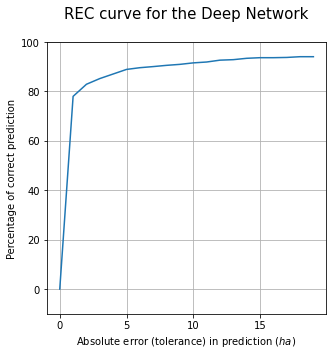

In [64]:
rec_NN=[]
for i in range(tol_max):
    rec_NN.append(rec(y_pred,test_y,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Deep Network\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_NN)